<a href="https://colab.research.google.com/github/adityaag121/edintelligence-hackathon/blob/main/Challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EdIntelligence Neurolabs AI compeition

This notebook is heavily inspired from Detectron2's Beginner Tutorial.

## Installing dependencies and setup

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 7.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=7b07b273326c4856cda5d33f7b589f5a501c86f731c85a6775b416af44eef2a3
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 7.2MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 2.2MB 10.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210220-cp36-none-any.whl size=52292 sha256=a6aae0733a47e454c2f6c94251c331c0d16be04cc7a0f5b80028f8b4f1692cfb
  Stored in directory: /root/.cache/pip/wheels/a1/af/2b/42e10bc07a70a2776e1a011d058a952db114a60f7bc8aa2199
  Created wheel for iopath: filename=iopath-0.1.4-cp36-none-any.whl size=15571 sha256=651999d8cf09e1d20d25f0d1aacd082d71e8440eeb9d21a10df27c384c26daa1
  Stored in directory: /root/.cache/pip/wheels/54/3b/fb/25b60ef5989e3f5fd76fdc575c922e6e59066ddbd1b44756a9
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import train_test_split

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader 
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



## Setup the synthetic data

Let's access the data. First you need to make sure that you make the public data available as a shortcut on your drive.

In [ ]:
drive.mount('/content/drive')
FOLDER_OF_COMPETITION_IN_YOUR_DRIVE = 'EdIntelligence-Neurolabs-Hackathon'
for i in Path("/content/drive/MyDrive/" + FOLDER_OF_COMPETITION_IN_YOUR_DRIVE).iterdir():
  print(i)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EdIntelligence-Neurolabs-Hackathon/common
/content/drive/MyDrive/EdIntelligence-Neurolabs-Hackathon/challenge-1
/content/drive/MyDrive/EdIntelligence-Neurolabs-Hackathon/challenge-2


In [ ]:
images_dir = Path("/content/drive/MyDrive/"+FOLDER_OF_COMPETITION_IN_YOUR_DRIVE+"/common/train/syn/images")
annotations_csv_f = Path("/content/drive/MyDrive/"+FOLDER_OF_COMPETITION_IN_YOUR_DRIVE+"/common/train/syn/annotations-detection.csv")

In [ ]:
from detectron2.structures import BoxMode

class Annotations:
  def __init__(self):
    self.annotations = None
    self.categories = None

  def compute(self):
    if self.annotations != None:
      return self.annotations

    # first read all the information
    csv_data = {}
    with annotations_csv_f.open() as f:
      for line in f:
        image_name, xmin, ymin, xmax, ymax, label = line.rstrip().split(",")
        if image_name not in csv_data:
          csv_data[image_name] = []
        csv_data[image_name].append([xmin,ymin,xmax,ymax,label])
    print(f"Finished reading data. Images: {len(csv_data.keys())}")

    # get all the labels and sort them (use a dictionary for O(1) lookup)
    categories = []
    for anns in csv_data.values():
      for ann in anns:
        label = ann[4]
        if not label in categories:
          categories.append(label)
    categories = sorted(categories)
    print(f"First 10 categories are {categories[:10]}")
    self.categories = categories
    categories_map = {label:idx for idx,label in enumerate(categories)}

    # convert this to the format that detectron2 wants
    data = []
    for idx, image_name in enumerate(csv_data.keys()):

      if idx >= 600: # load more if you want!
        break

      if idx%50 == 0:
        print(f"Processed {idx} images.")
      record = {}

      filename = str(images_dir/image_name)
      height, width = cv2.imread(filename).shape[:2]
      
      record["file_name"] = filename
      record["image_id"] = idx
      record["height"] = height
      record["width"] = width

      annotations = csv_data[image_name]
      objs = []
      for annotation in annotations:
        xmin, ymin, xmax, ymax, label = annotation
        objs.append({
            "bbox": [float(xmin),float(ymin),float(xmax),float(ymax)],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": categories_map[label]
        })
      record["annotations"] = objs
      data.append(record)
    
    self.annotations = data

anns = Annotations()
anns.compute()
print(f"Finished loading annotations.")

Finished reading data. Images: 13200
First 10 categories are ['apple_green', 'apple_red_1', 'apple_red_2', 'apple_red_3', 'baby_food_1', 'baby_food_10', 'baby_food_2', 'baby_food_3', 'baby_food_4', 'baby_food_5']
Processed 0 images.
Processed 50 images.
Processed 100 images.
Processed 150 images.
Processed 200 images.
Processed 250 images.
Processed 300 images.
Processed 350 images.
Processed 400 images.
Processed 450 images.
Processed 500 images.
Processed 550 images.
Finished loading annotations.


In [ ]:
# let's register this dataset (unregistered if it exists.)
def register(name, load_fn, labels):
  if name in DatasetCatalog.list():
    DatasetCatalog.remove(name)
  if name in MetadataCatalog.list():
    MetadataCatalog.remove(name)
  
  DatasetCatalog.register(name, load_fn)
  MetadataCatalog.get(name).set(thing_classes=labels)

# register("train", lambda:anns.annotations, anns.categories)
# print("Dataset registered.")

Dataset registered.


Let's visualize some of that data.

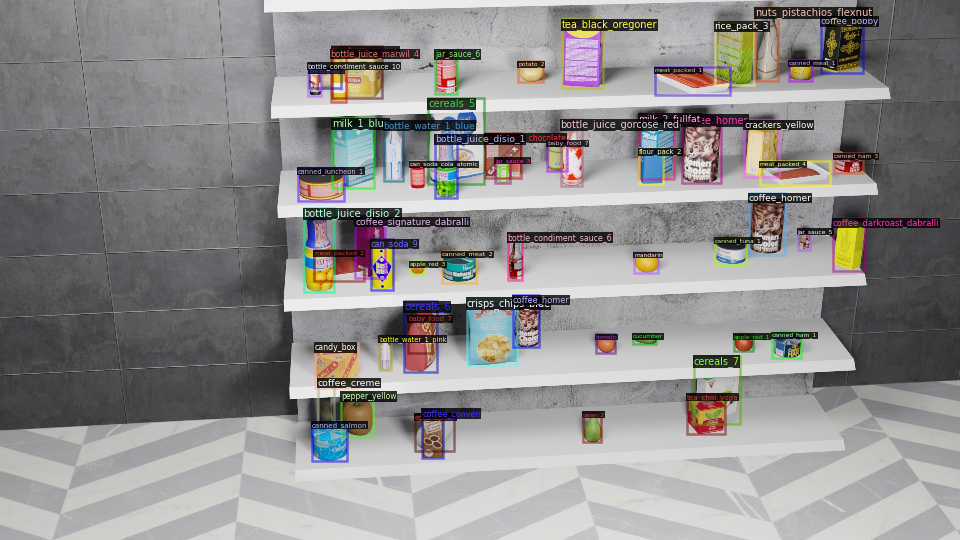

In [ ]:
for d in random.sample(anns.annotations, 1):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train"), scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
Train,val=train_test_split(anns.annotations, shuffle=True)
register("train", lambda:Train, anns.categories)
register("val", lambda:val, anns.categories)
print("Datasets registered.")

## Now we train!

We setup the config for training with detectron2.

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 65000    # number of iterations (see note about epoch)
# cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(anns.categories)  # number of classes


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/21 08:01:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 84.3MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (331, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (331,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (1320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (1320,) in the model! You might want to double check if this is expected.


[02/21 08:01:47 d2.engine.train_loop]: Starting training from iteration 0
[02/21 08:01:54 d2.utils.events]:  eta: 0:05:14  iter: 19  total_loss: 7.224  loss_cls: 5.943  loss_box_reg: 0.6971  loss_rpn_cls: 0.3703  loss_rpn_loc: 0.1747  time: 0.2622  data_time: 0.0551  lr: 1.9981e-05  max_mem: 2578M
[02/21 08:01:59 d2.utils.events]:  eta: 0:05:03  iter: 39  total_loss: 6.624  loss_cls: 5.446  loss_box_reg: 0.6732  loss_rpn_cls: 0.1847  loss_rpn_loc: 0.1606  time: 0.2612  data_time: 0.0024  lr: 3.9961e-05  max_mem: 2578M
[02/21 08:02:04 d2.utils.events]:  eta: 0:04:55  iter: 59  total_loss: 5.148  loss_cls: 4.224  loss_box_reg: 0.7238  loss_rpn_cls: 0.07561  loss_rpn_loc: 0.1617  time: 0.2589  data_time: 0.0023  lr: 5.9941e-05  max_mem: 2608M
[02/21 08:02:09 d2.utils.events]:  eta: 0:04:49  iter: 79  total_loss: 3.095  loss_cls: 2.099  loss_box_reg: 0.7097  loss_rpn_cls: 0.0921  loss_rpn_loc: 0.1617  time: 0.2580  data_time: 0.0024  lr: 7.9921e-05  max_mem: 2608M
[02/21 08:02:14 d2.utils.

KeyError: ignored

A few things to note:
- An _epoch_ is a single pass of your training data. You calculate it with `cfg.SOLVER.IMS_PER_BATCH` and `cfg.SOLVER.MAX_ITER`. Example: if you have 1000 images, 2 `IMS_PER_BATCH`, then you would need 500 `MAX_ITER` for 1 _epoch_
- Make sure that the `cfg.MODEL.ROI_HEADS.NUM_CLASSES` is equal to the number of classes! 
- Learning 330 classes is hard! It will take quite a few epochs. The localization problem should show results sooner.

## Evaluation

In the example, we will just evaluate against the training dataset. However, you should set aside some of the data from training so that you can use it for evaluation.

In [ ]:
test_dataset_name = "val" # this should be a different dataset that you've registered
cfg.MODEL.WEIGHTS = os.path.join("./drive/MyDrive/model_final.pth")  # path to the model we trained earlier
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.DATASETS.TEST = (test_dataset_name,) 

evaluator = COCOEvaluator(test_dataset_name, cfg, False, output_dir="./output/")
loader = build_detection_test_loader(cfg, test_dataset_name)
eval_results = inference_on_dataset(trainer.model, loader, evaluator)
print(eval_results)

WARNING [02/21 10:08:35 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[02/21 10:08:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/21 10:08:35 d2.data.common]: Serializing 600 elements to byte tensors and concatenating them all ...
[02/21 10:08:35 d2.data.common]: Serialized dataset takes 3.06 MiB
[02/21 10:08:35 d2.evaluation.evaluator]: Start inference on 600 images
[02/21 10:08:38 d2.evaluation.evaluator]: Inference done 11/600. 0.1250 s / img. ETA=0:01:14
[02/21 10:08:43 d2.evaluation.evaluator]: Inference done 52/600. 0.1217 s / img. ETA=0:01:08
[02/21 10:08:48 d2.evaluation.evaluator]: Inference done 93/600. 0.1212 s / img. ETA=0:01:03
[02/21 10:08:54 d2.evaluation.evaluator]: Inference done 134/600. 0.1212 s / img. ETA=0:00:58
[02/21 10:08:59 d2.evaluation.evaluator]: Infer

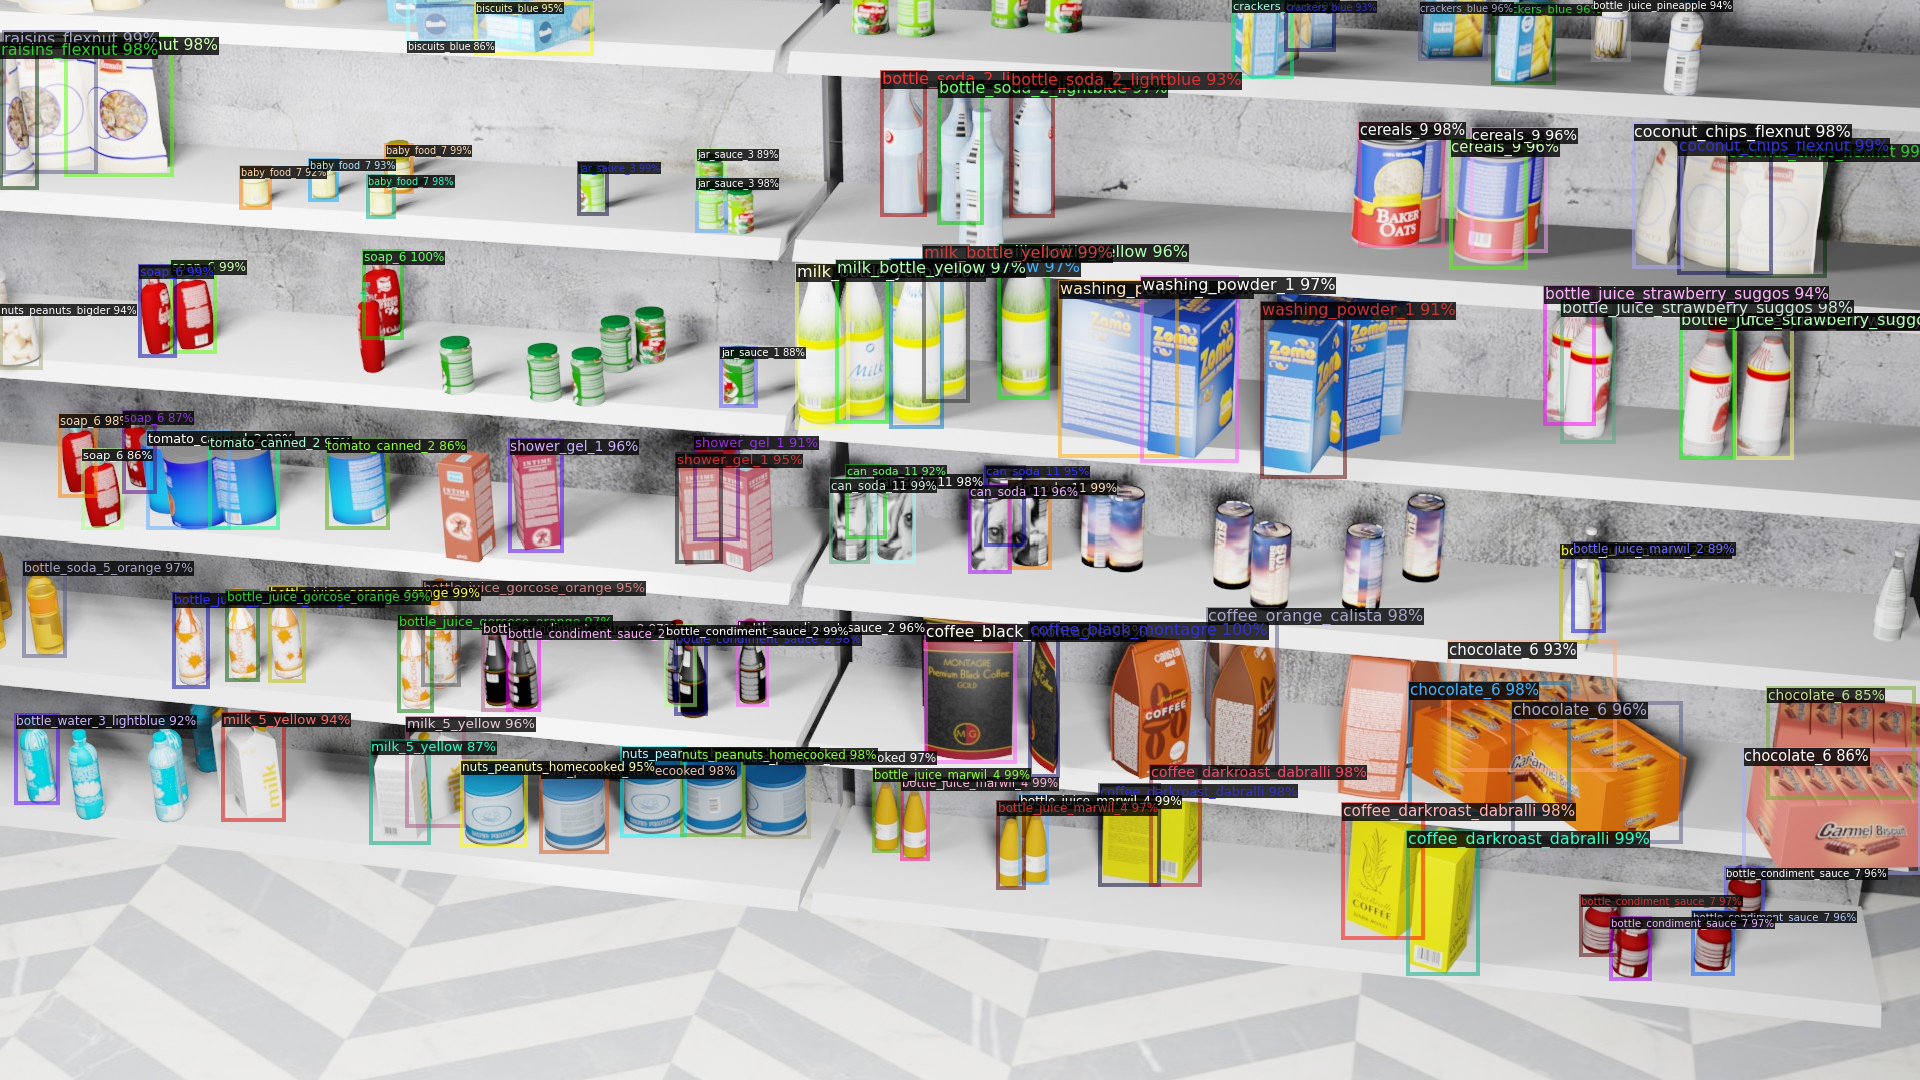

In [ ]:
# visualize inference on some images
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1 # if you want to allow predictions with lower accuracy
predictor = DefaultPredictor(cfg)
for d in random.sample(DatasetCatalog.get(test_dataset_name), 1):
  img = cv2.imread("/content/drive/MyDrive/EdIntelligence-Neurolabs-Hackathon/challenge-1/test/images/BtaphZtg_0.jpg")#d["file_name"])
  outputs = predictor(img)
  visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(test_dataset_name), scale=1)
  # out = visualizer.draw_dataset_dict(d) # these are the ground truths 
  # cv2_imshow(out.get_image()[:, :, ::-1])
  out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

## Running inference on test images

In [ ]:
import csv
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor=DefaultPredictor(cfg)
real_images_dir = Path("/content/drive/MyDrive/EdIntelligence-Neurolabs-Hackathon/challenge-1/test/images")
with open('predictions.csv','w') as file:
  writer = csv.writer(file)
  for num,f in enumerate(real_images_dir.iterdir()):
    output=predictor(cv2.imread(str(f)))
    output=output['instances'].to('cpu')
    for i,box in enumerate(output.pred_boxes):
      row=[f.name]+box.numpy().astype(int).tolist()+[anns.categories[output.pred_classes[i]]]
      writer.writerow(row)
      # break
    print(num,f.name,len(output))
    # break

0 AFWXWEaE_0.jpg 50
1 AIhATvuM_0.jpg 54
2 ahTXKHNd_0.jpg 52
3 AGXpRAay_0.jpg 47
4 abAnNYEi_0.jpg 65
5 anfDqowG_0.jpg 50
6 AOfOlbSQ_0.jpg 56
7 ApXOhdHV_0.jpg 54
8 aqISAevX_0.jpg 44
9 aQGqvsIs_0.jpg 65
10 aqYfappg_0.jpg 67
11 aNZXHNfQ_0.jpg 38
12 AstMHKZh_0.jpg 52
13 ATseIXEo_0.jpg 53
14 AtwYsSsR_0.jpg 41
15 AubcHYyg_0.jpg 48
16 ARDJtogo_0.jpg 57
17 AuFmBDBT_0.jpg 60
18 aVIeSzcE_0.jpg 61
19 avMQDVIF_0.jpg 52
20 AwApOiYH_0.jpg 43
21 AXxuqcRX_0.jpg 56
22 aUSCEXOD_0.jpg 66
23 bDTsPBQI_0.jpg 53
24 ayTpkQWi_0.jpg 56
25 BEEtwzcV_0.jpg 48
26 BHEVGKch_0.jpg 43
27 bHmEqWHC_0.jpg 61
28 bCtSQTDL_0.jpg 57
29 BRfEwsuY_0.jpg 70
30 BryHRYzp_0.jpg 51
31 BnMvCRYS_0.jpg 55
32 bJmQfabh_0.jpg 56
33 bsZRICtR_0.jpg 60
34 BlXixbSt_0.jpg 53
35 aemnyrEi_0.jpg 65
36 aGBertiy_0.jpg 53
37 AfOKZIlM_0.jpg 62
38 ADwuhoQx_0.jpg 61
39 aaGWwzWb_0.jpg 69
40 AfOwhtSH_0.jpg 62
41 AkOJHoGW_0.jpg 50
42 aHbOxXoc_0.jpg 60
43 AIufseIJ_0.jpg 68
44 agnVkfCX_0.jpg 60
45 AgeuMngB_0.jpg 62
46 AiiJujwL_0.jpg 47
47 AwatUcGD_0.jpg 65
48

The results are a little different from the `evaluator.py` script given to you.

__Remember__: for submission, you need to convert your inference results into the CSV format and run them through the `evaluator.py` script!

## Where do we go from here?

There are many things to do:
- Reserve some of the dataset for testing.
- Implement/use an evaluator for validation as seen [here](https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e).
- Use data augmentations ([Albumentations](https://albumentations.ai/) is great).
- Try different models from the model zoo. 
- Try out the second task!